# AMAL - TP 4 - Réseaux récurrents

In [1]:
import numpy as np
import torch
from datamaestro import prepare_dataset 
from torch.utils.tensorboard import SummaryWriter
import time
import csv
import pandas as pd
import os
from matplotlib import pyplot as plt

In [2]:
torch.autograd.set_detect_anomaly(True)

## Exercice 1

In [11]:
class RNN_new(torch.nn.Module):
    def __init__(self, dim, latent, batch):
        super(RNN_new, self).__init__()
        
        self.Wi = torch.nn.Linear(dim, latent, bias=False)
        self.Wh = torch.nn.Linear(latent, latent)
        self.latent = latent
        self.h = torch.zeros(batch, latent, requires_grad=True)
        
    def one_step(self, x, h):
        return torch.nn.Tanh()(self.Wi(x) + self.Wh(h)) 
    
    def forward(self, x):
        length, batch = x.shape[0], x.shape[1] 
        hs = []
        hs.append(self.one_step(x[0], self.h))
        for i in range(1, length):
            hs.append(self.one_step(x[i], hs[-1]))
        return hs[-1]
       # return torch.cat(hs, dim=0)

In [5]:
class RNN(torch.nn.Module):
    def __init__(self, dim, latent, batch):
        super(RNN, self).__init__()
        
        self.Wi = torch.nn.Linear(dim, latent, bias=False)
        
   
    def forward(self, x):
        return torch.nn.Tanh()(self.Wi(x))[0]

Test:

In [5]:
n_cities = 2
dim = 2
batch = 16
latent = 20
length = 100

In [6]:
temp_data = pd.read_csv('tempAMAL_train.csv')
temp_data = temp_data.iloc[:,1: 1+n_cities]
data = np.asarray(temp_data)
cols = temp_data.columns

n_times = data.shape[0]
data[np.isnan(data)] = np.mean(data[~np.isnan(data)])
#data = data / 280
#data *= 10 * n_times/ (np.linalg.norm(data)*length)
data = (data - np.min(data)) / (np.max(data) - np.min(data))

In [7]:
increment = np.repeat(np.arange(0, length), batch).reshape((length, batch))

In [12]:
model = torch.nn.Sequential(
        RNN_new(dim, latent, batch),
        torch.nn.Linear(latent, n_cities)
   #     torch.nn.Tanh() # à changer ?
)

In [13]:
def test_model(n_test):
    p_true = 0

    for i in range(n_test):
        with torch.no_grad():
            random_cities = np.random.randint(0, n_cities, size=(batch))
            random_times = np.random.randint(0, n_times-length-dim, size=(batch))
            x_numpy = np.zeros((length, batch, dim))
            for k in range(dim):
                x_numpy[:, :, k] = data[np.repeat(np.reshape(random_times+k, (1, batch)), length, axis=0)+increment, random_cities]
            x = torch.from_numpy(x_numpy).float()
            predicted_cities = model(x).detach().numpy()
            ok = np.sum(np.argmax(predicted_cities, axis=1) == random_cities) / batch
            p_true += ok

    print(p_true / n_test)
    
test_model(100)

0.505


In [14]:
#optim = torch.optim.SGD(params=model.parameters(),lr=EPS)
optim = torch.optim.Adam(params=[x for x in model.parameters()] + [model[0].h], lr=1e-3,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
loss = torch.nn.CrossEntropyLoss()

In [15]:
n_train = 1000
batch * length * dim * n_train / (data.shape[0]*data.shape[1])

143.94961763382815

In [ ]:
writer = SummaryWriter()
losses = []
for i in range(n_train):
    # each time: we see batch * length data
    optim.zero_grad()
    random_cities = np.random.randint(0, n_cities, size=(batch))
    random_times = np.random.randint(0, n_times-length-dim, size=(batch))
    x_numpy = np.zeros((length, batch, dim))
    for k in range(dim):
        x_numpy[:, :, k] = data[np.repeat(np.reshape(random_times+k, (1, batch)), length, axis=0)+increment, random_cities]
    x = torch.from_numpy(x_numpy).float()
    l = loss(model(x), torch.from_numpy(random_cities))
    l.backward()
    optim.step()
    writer.add_scalar('Loss/train', l, i)
    losses.append(l)

In [20]:
l

tensor(0.6925, grad_fn=<NllLossBackward>)

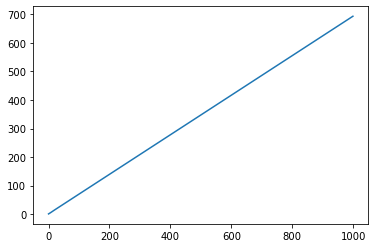

In [21]:
plt.plot(np.cumsum(losses))

In [22]:
print(model[0].h.grad)
print(model[0].h)

tensor([[ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [-2.4261e-40, -6.8690e-40],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00]])
tensor([[ 1.3365,  1.9567],
        [ 0.9305,  0.6971],
        [-0.0466, -0.7798],
        [ 3.0520, -0.3530],
        [-1.9174, -1.1763],
        [ 1.2350,  0.1727],
        [-1.6149, -1.4955],
        [-1.9559, -1.2249]], requires_grad=True)


In [23]:
test_model(100)

0.4967375


## Exercice 2

In [66]:
n_cities = 2
dim = 1
batch = 8
latent = 5
length = 10

In [67]:
increment = np.repeat(np.arange(0, length), batch).reshape((length, batch))

In [68]:
class RNN_new(torch.nn.Module):
    def __init__(self, dim, latent, batch):
        super(RNN_new, self).__init__()
        
        self.Wi = torch.nn.Linear(dim, latent, bias=False)
        self.Wh = torch.nn.Linear(latent, latent)
        self.latent = latent
        self.h = torch.zeros(batch, latent, requires_grad=True)
        
    def one_step(self, x, h):
        return torch.nn.Tanh()(self.Wi(x) + self.Wh(h)) 
    
    def forward(self, x):
        length, batch = x.shape[0], x.shape[1] 
        hs = []
        hs.append(self.one_step(x[0], self.h))
        for i in range(1, length):
            hs.append(self.one_step(x[i], hs[-1]))
        return torch.cat(hs, dim=0)

In [70]:
model = torch.nn.Sequential(
        RNN_new(dim, latent, batch),
        torch.nn.Linear(latent, 1),
        torch.nn.Sigmoid()
)

In [71]:
optim = torch.optim.Adam(params=[x for x in model.parameters()] + [model[0].h], lr=1e-3,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
loss = torch.nn.MSELoss()

In [77]:
n_test = 1000
p_true = 0
l = 0

for i in range(n_test):
    with torch.no_grad():
        random_cities = np.random.randint(0, n_cities, size=(batch))
        random_times = np.random.randint(0, n_times-length-dim, size=(batch))
        x_numpy = np.zeros((length, batch, dim))
        true_temp = np.zeros((length, batch, dim))
        for k in range(dim):
            x_numpy[:, :, k] = data[np.repeat(np.reshape(random_times+k, (1, batch)), length, axis=0)+increment, random_cities]
            true_temp[:, :, k] = data[np.repeat(np.reshape(random_times+k+1, (1, batch)), length, axis=0)+increment, random_cities]
        x = torch.from_numpy(x_numpy).float()
        predicted_temp = model(x)
        l += loss(predicted_temp, torch.from_numpy(true_temp.reshape((length*batch, 1))).float())
        
print(l/n_test)

tensor(0.0360)


In [78]:
n_train = 2000
batch * length * dim * n_train / (data.shape[0]*data.shape[1])

7.197480881691408

In [80]:
writer = SummaryWriter()
losses = []
for i in range(n_train):
    # each time: we see batch * length data
    optim.zero_grad()
    random_cities = np.random.randint(0, n_cities, size=(batch))
    random_times = np.random.randint(0, n_times-length-dim, size=(batch))
    x_numpy = np.zeros((length, batch, dim))
    true_temp = np.zeros((length, batch, dim))
    for k in range(dim):
        x_numpy[:, :, k] = data[np.repeat(np.reshape(random_times+k, (1, batch)), length, axis=0)+increment, random_cities]
        true_temp[:, :, k] = data[np.repeat(np.reshape(random_times+k+1, (1, batch)), length, axis=0)+increment, random_cities]
    x = torch.from_numpy(x_numpy).float()
    l = loss(model(x), torch.from_numpy(true_temp.reshape((length*batch, 1))).float())
    l.backward()
    optim.step()
    writer.add_scalar('Loss/train', l, i)
    losses.append(l)

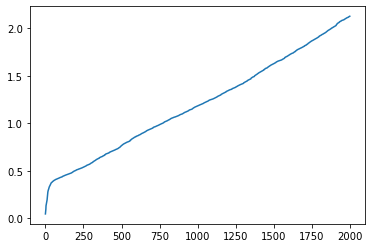

In [81]:
plt.plot(np.cumsum(losses))

In [82]:
model[0].Wi.weight.grad

tensor([[-3.7373e-05],
        [-3.5135e-04],
        [-3.8532e-03],
        [-2.0195e-04],
        [ 2.4737e-03]])

In [83]:
model[0].Wi.weight

Parameter containing:
tensor([[-0.4823],
        [-1.1931],
        [-2.2775],
        [-1.1259],
        [ 2.1225]], requires_grad=True)

In [85]:
n_test = 1000
p_true = 0
l = 0
l_dummy = 0

for i in range(n_test):
    with torch.no_grad():
        random_cities = np.random.randint(0, n_cities, size=(batch))
        random_times = np.random.randint(0, n_times-length-dim, size=(batch))
        x_numpy = np.zeros((length, batch, dim))
        true_temp = np.zeros((length, batch, dim))
        for k in range(dim):
            x_numpy[:, :, k] = data[np.repeat(np.reshape(random_times+k, (1, batch)), length, axis=0)+increment, random_cities]
            true_temp[:, :, k] = data[np.repeat(np.reshape(random_times+k+1, (1, batch)), length, axis=0)+increment, random_cities]
        x = torch.from_numpy(x_numpy).float()
        predicted_temp = model(x)
        l += loss(model(x), torch.from_numpy(true_temp.reshape((length*batch, 1))).float())
        l_dummy += loss(x, torch.from_numpy(true_temp).float())
        
print(l/n_test)
print(l_dummy/n_test)

tensor(0.0009)
tensor(0.0006)
